# Time Series Workshop - ARIMA Exercises

This notebook contains the exercises for the ARIMA section of the workshop.

The exercises will cover the following topics:
1. Visualizing your time series dataset _(3 minutes)_
2. Splitting your time series data into train and test _(3 minutes)_
3. Assessing the stationarity of your time series _(5 minutes)_
4. Manually apply differencing to your time series _(5 minutes)_
5. Perform model estimation with different parameter values _(5 minutes)_
6. Implement the auto_arima() function to do the work for you _(5 minutes)_

Run the code below to load the required packages and functions

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from IPython.display import HTML, display
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def create_manual_ARIMA_forecast(train, test, p = 1, d = 0, q = 0, P = 0, D = 0, Q = 0, m = 12):
    # Estimate the model
    model = pm.ARIMA(order = (p, d, q), seasonal_order = (P, D, Q, m))
    try:
        model.fit(train)
    except ValueError:
        print("Oops! With these settings the ARIMA function breaks. Please try again with different settings...")
        return
    # Make forecast using the model
    point_fc, conf_int = model.predict(n_periods = len(test), return_conf_int = True)
    # Determine model performance
    test_RMSE = np.sqrt(mean_squared_error(test, point_fc))
    # Reformat forecast data
    plot_data = pd.concat([train, test], axis = 0)
    plot_data = pd.concat([plot_data, pd.DataFrame(point_fc, index = test.index, columns=["forecast"])], axis = 1)
    conf_int = pd.DataFrame(conf_int, index = test.index, columns=["lower_bound", "upper_bound"])
    # Create and show a plot of the forecast
    plot_data.plot().set_title(f"ARIMA forecast({p},{d},{q})({P},{D},{Q}){m} - test RMSE = {round(test_RMSE,1)}")
    pyplot.fill_between(conf_int.index, conf_int.lower_bound, conf_int.upper_bound, color = "orange", alpha=.1)
    pyplot.show()
    
hide_solution_code = None
HTML('''
    <script>
        code_show=true; 
        function code_toggle() {
          if (code_show) {
            $('div.input').each(function(id) {
              el = $(this).find('.cm-variable:first');
              if (el.text() == 'hide_solution_code') {
                $(this).hide();
              }
            });
            $('div.output_prompt').css('opacity', 0);
          } else {
            $('div.input').each(function(id) {
              $(this).show();
            });
            $('div.output_prompt').css('opacity', 1);
          }
          code_show = !code_show
        } 
        $( document ).ready(code_toggle);
    </script>
    <form class = "main_button" action="javascript:code_toggle()">
        <input type="submit" value="Click here to toggle on/off the solution code for ALL exercises">
    </form>
''')

## Instruction

For every exercise, you are strongly encouraged to:
* **first**, try for yourself
* **second**, ask one of your neighbors for help
* **third**, as last resort, sneak a peak at the solution

You can toggle the solution code by clicking the button above, **please click it to make sure the example solution below is hidden!**

In [2]:
hide_solution_code

# PLEASE CLICK THE 'Click here to toggle ...' BUTTON ABOVE TO HIDE THIS AND ALL THE OTHER SOLUTIONS!


## Loading the data

We will be using a dataset from the pmdarima package:
* Total wine sales by Australian wine makers
* It has a monthly frequency
* It ranges from January 1980 to August 1994

Run the code below to load and prepare the dataset.

In [14]:
data = pm.datasets.load_wineind(as_series = True)
data.index = pd.to_datetime(data.index)
data = data.to_frame('wine_sales')
data.head()

,wine_sales
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


## Exercise 1:
Visualize the time-series (using your own favorite way of plotting).

_Available time: 3 minutes_

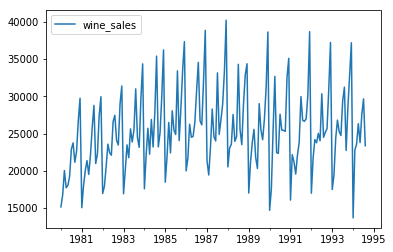

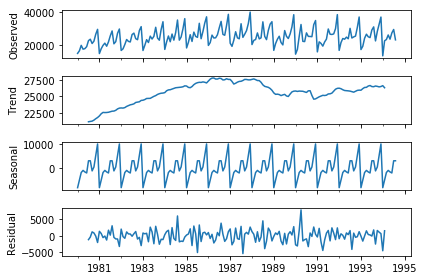

In [4]:
# Standard line plot of the time-series
data.plot()
pyplot.show()
# We can also decompose the time-series into Trend, Seasonal and Residual (mostly noise) components
seasonal_decompose(data, model = 'additive').plot()
pyplot.show()

In [5]:
# Possible solution
'''
# Standard line plot of the time-series
data.plot()
pyplot.show()
# We can also decompose the time-series into Trend, Seasonal and Residual (mostly noise) components
seasonal_decompose(data, model = 'additive').plot()
pyplot.show()
'''
hide_solution_code

## Splitting the data

Before we start training any model, we should split our data into a train and test set.<br>
Any decision we make should be based on the train set, as we assume we don't know anything about the test set.<br>
The test set should only be used at the very end to evaluate the performance of our model.

## Exercise 2:
Split the data into:
* a train set containing all wine sales until the end of 1990
* a test set containing everything else

**NOTE**: In time series forecasting, it's very important that your data is sorted (in ascending order) before you start splitting!

_Available time: 3 minutes_

In [6]:
data = data.sort_index(ascending = True)
train, test = data.loc[:'1990-12-01'], data['1991-01-01':]
print(f"Train set has length of {len(train)} months, from {min(train.index)} to {max(train.index)}")
print(f"Test set has length of {len(test)} months, from {min(test.index)} to {max(test.index)}")

Train set has length of 132 months, from 1980-01-01 00:00:00 to 1990-12-01 00:00:00
Test set has length of 44 months, from 1991-01-01 00:00:00 to 1994-08-01 00:00:00


In [7]:
# Possible solution
'''
data = data.sort_index(ascending = True)
train, test = data.loc[:'1990-12-01'], data['1991-01-01':]
print(f"Train set has length of {len(train)} months, from {min(train.index)} to {max(train.index)}")
print(f"Test set has length of {len(test)} months, from {min(test.index)} to {max(test.index)}")
'''
hide_solution_code

## Non-seasonal ARIMA model parameters
For simplicity, let's start with a non-seasonal ARIMA model, for which we would need to determine the following parameters:
* p = order of the autoregressive part
* d = degree of first differencing involved
* q = order of the moving average part

First step is to determine the number of times of differencing required to create a stationary time series (which it might already be!)

## Exercise 3:
Determine whether the time series is stationary or not, by:
* Visually inspecting the time series (use your plot(s) from exercise one)
* Testing for stationarity, using one or more of [the available statistical test in pmdarima](https://www.alkaline-ml.com/pmdarima/modules/classes.html#pmdarima-arima-arima-estimator-differencing-tests)

**NOTE**: when drawing conclusions based on the statistical tests, ask yourself: _What is the null hypothesis I try to reject?_

_Available time: 5 minutes_

In [8]:
# We can conduct a Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
KPSS_test = pm.arima.stationarity.KPSSTest(alpha = 0.05)
print(
    f"Results of the KPSS test:\n"
    f"pval:\t{KPSS_test.is_stationary(train)[0]}\n"
    f"sig:\t{KPSS_test.is_stationary(train)[1]}\n"
)
# True means we CAN REJECT the null hypothesis that the time-series IS stationary, so we need to do differencing
# False means we CAN'T REJECT the null hypothesis that the time-series IS stationary, so we don't have to do differencing

# We can also use a test which can indicate how many times we need to difference our data to make it stationary
available_tests = ['adf', 'kpss', 'pp']
print("Required differencing according to tests:")
for t in available_tests:
    print(f"{t}:\t{pm.arima.utils.ndiffs(train, test = t)} differencing is required")

Results of the KPSS test:
pval:	0.01
sig:	True

Required differencing according to tests:
adf:	0 differencing is required
kpss:	1 differencing is required
pp:	0 differencing is required


In [9]:
# Possible solution
'''
# We can conduct a Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
KPSS_test = pm.arima.stationarity.KPSSTest(alpha = 0.05)
print(
    f"Results of the KPSS test:\n"
    f"pval:\t{KPSS_test.is_stationary(train)[0]}\n"
    f"sig:\t{KPSS_test.is_stationary(train)[1]}\n"
)
# True means we CAN REJECT the null hypothesis that the time-series IS stationary, so we need to do differencing
# False means we CAN'T REJECT the null hypothesis that the time-series IS stationary, so we don't have to do differencing

# We can also use a test which can indicate how many times we need to difference our data to make it stationary
available_tests = ['adf', 'kpss', 'pp']
print("Required differencing according to tests:")
for t in available_tests:
    print(f"{t}:\t{pm.arima.utils.ndiffs(train, test = t)} differencing is required")
'''
hide_solution_code

## Differencing
Irrespective of the outcomes in the previous exercise, let's assume we need to apply a first order difference to make the time series stationary.

## Exercise 4
Make the time series stationary, by:
* Calculating the first order difference of the time series
* Plotting the first order difference to assess whether it is indeed now stationary

_Available time: 5 minutes_

First we add a new column, which is a lagged (shifted down by one) version of the wine_sales column:
            wine_sales  wine_sales_lagged
1980-01-01       15136                NaN
1980-02-01       16733            15136.0
1980-03-01       20016            16733.0
1980-04-01       17708            20016.0
1980-05-01       18019            17708.0

Then we use the lagged column to calculate the first order difference:
            wine_sales  wine_sales_lagged  wine_sales_diff
1980-01-01       15136                NaN              NaN
1980-02-01       16733            15136.0           1597.0
1980-03-01       20016            16733.0           3283.0
1980-04-01       17708            20016.0          -2308.0
1980-05-01       18019            17708.0            311.0

Finally we loose the first row, which no longer contains data and keep only the differenced column:
            wine_sales_diff
1980-02-01           1597.0
1980-03-01           3283.0
1980-04-01          -2308.0
1980-05-

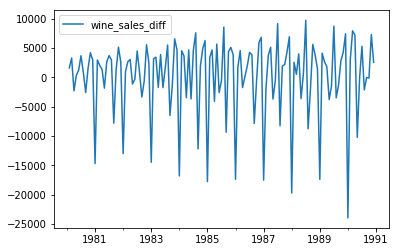

It seems to be stationary with regards to the mean, but maybe not entirely stationary with regards to the variance
(but for simplicity, we will ignore this for now)


In [10]:
print("First we add a new column, which is a lagged (shifted down by one) version of the wine_sales column:")
train_lagged = train.rename(columns={'wine_sales': 'wine_sales_lagged'}).shift(1)
train_lagged = pd.concat([train, train_lagged], axis = 1)
print(train_lagged.head())

print("\nThen we use the lagged column to calculate the first order difference:")
train_diff = train_lagged.assign(wine_sales_diff = train_lagged['wine_sales'] - train_lagged['wine_sales_lagged'])
print(train_diff.head())

print("\nFinally we loose the first row, which no longer contains data and keep only the differenced column:")
train_diff = train_diff[['wine_sales_diff']][1:]
print(train_diff.head())

print("\nLet's reapply the available tests to see if more differencing is required:")
available_tests = ['adf', 'kpss', 'pp']
for t in available_tests:
    print(f"{t}:\t{pm.arima.utils.ndiffs(train_diff, test = t)} differencing is required")

print("\nAnd finish with a plot to visually inspect whether out time series is now stationary:")
train_diff.plot()
pyplot.show()

print("It seems to be stationary with regards to the mean, but maybe not entirely stationary with regards to the variance\n(but for simplicity, we will ignore this for now)")

In [11]:
# Possible solution
'''
print("First we add a new column, which is a lagged (shifted down by one) version of the wine_sales column:")
train_lagged = train.rename(columns={'wine_sales': 'wine_sales_lagged'}).shift(1)
train_lagged = pd.concat([train, train_lagged], axis = 1)
print(train_lagged.head())

print("\nThen we use the lagged column to calculate the first order difference:")
train_diff = train_lagged.assign(wine_sales_diff = train_lagged['wine_sales'] - train_lagged['wine_sales_lagged'])
print(train_diff.head())

print("\nFinally we loose the first row, which no longer contains data and keep only the differenced column:")
train_diff = train_diff[['wine_sales_diff']][1:]
print(train_diff.head())

print("\nLet's reapply the available tests to see if more differencing is required:")
available_tests = ['adf', 'kpss', 'pp']
for t in available_tests:
    print(f"{t}:\t{pm.arima.utils.ndiffs(train_diff, test = t)} differencing is required")

print("\nAnd finish with a plot to visually inspect whether out time series is now stationary:")
train_diff.plot()
pyplot.show()

print("It seems to be stationary with regards to the mean, but maybe not entirely stationary with regards to the variance\n(but for simplicity, we will ignore this for now)")
'''
hide_solution_code

## Model estimation of seasonal ARIMA
Given the results from Exercise 3 and Exercise 4, we now know one of the parameters (d = 1) of the ARIMA model.<br>
We also know what we have monthly data, which means that there are 12 periods (months) in a year (so m = 12).<br>

However, we don't know yet what the other parameters (p, q, P, D, Q) should be.<br>
There are of course ways to analytically determine these as well, but for now let's just play around with some values.

## Exercise 5
Using the *create_manual_ARIMA_forecast()* function and values d = 1 and m = 12, play around with the other parameters to minimise the Root Mean Square Error (RMSE) on the test set (which is automatically reported in the output of the function).

**NOTE**: use the original (undifferenced) train data, as the function will do the differencing for us.

_Available time: 5 minutes_

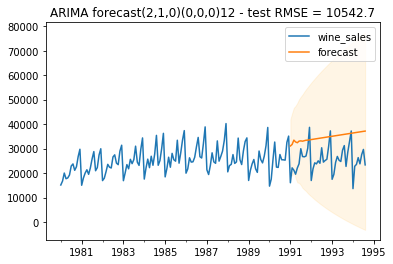

In [15]:
# Adjust/copy the code below to try out different combinations of parameters
create_manual_ARIMA_forecast(train, test, p=2, d=1, q=0, P=0, D=0, Q=0, m=12)



## Automatic model selection
As discussed in the presentation, there is also an *auto_arima()* function available in the pmdarima package.<br>
Documentation on the function is available [here](https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima), more information on the algorithm itself is available [here](https://otexts.com/fpp2/arima-r.html).

## Exercise 6
Implement the pm.auto_arima() function to automatically determine the 'optimal' model.

**NOTE**: run the function with *trace = True* to get status updates, you can use *error_action = 'ignore'* and *suppress_warnings = True* to hide some of the verbose errors/warnings.

_Available time: 5 minutes_

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2235.404, BIC=2246.521, Fit time=0.184 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2263.704, BIC=2269.262, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2247.319, BIC=2258.436, Fit time=0.109 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2233.128, BIC=2244.244, Fit time=0.165 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2233.797, BIC=2247.693, Fit time=0.282 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2236.789, BIC=2245.126, Fit time=0.047 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2233.834, BIC=2247.730, Fit time=0.326 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2235.698, BIC=2252.372, Fit time=0.826 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2232.708, BIC=2246.603, Fit time=0.442 seconds
Fit ARIMA: order=(1, 1, 0) s

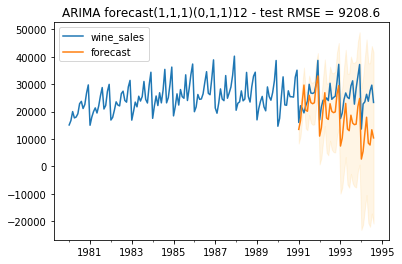

In [13]:
# Use auto_arima to do model selection
model = pm.auto_arima(
    # Provide (monthly) dataset
    y = train, 
    m = 12, 
    # Set (p, d, q) ranges
    start_p = 1, max_p = 3,
    d = 1, max_d = 2,
    start_q = 1, max_q = 3,
    # Set (P, D, Q) ranges
    start_P = 0, max_P = 2,
    D = 1, max_D = 1, 
    start_Q = 0, max_Q = 2,
    # Use the corrected AIC
    information_criterion = 'aicc',    
    # Use stepwise to limit runtime
    stepwise = True,
    # Set verbose
    trace = True,
    error_action = 'ignore',  
    suppress_warnings = True
)
print(f"\nFinal model has order (p, d, q) of {model.get_params()['order']}")
print(f"Final model has seasonal order (P, D, Q, m) of {model.get_params()['seasonal_order']}")
print(f"Final model has AICc of {round(model.aicc(),1)}")
test_RMSE = np.sqrt(mean_squared_error(test, model.predict(n_periods = len(test))))
print(f"Final model has test RMSE of {round(test_RMSE,1)}")
# Lets also visualize our final model
create_manual_ARIMA_forecast(train, test, p=1, d=1, q=1, P=0, D=1, Q=1, m=12)

In [14]:
# Possible solution
'''
# Use auto_arima to do model selection
model = pm.auto_arima(
    # Provide (monthly) dataset
    y = train, 
    m = 12, 
    # Set (p, d, q) ranges
    start_p = 1, max_p = 3,
    d = 1, max_d = 2,
    start_q = 1, max_q = 3,
    # Set (P, D, Q) ranges
    start_P = 0, max_P = 2,
    D = 1, max_D = 1, 
    start_Q = 0, max_Q = 2,
    # Use the corrected AIC
    information_criterion = 'aicc',    
    # Use stepwise to limit runtime
    stepwise = True,
    # Set verbose
    trace = True,
    error_action = 'ignore',  
    suppress_warnings = True
)
print(f"\nFinal model has order (p, d, q) of {model.get_params()['order']}")
print(f"Final model has seasonal order (P, D, Q, m) of {model.get_params()['seasonal_order']}")
print(f"Final model has AICc of {round(model.aicc(),1)}")
test_RMSE = np.sqrt(mean_squared_error(test, model.predict(n_periods = len(test))))
print(f"Final model has test RMSE of {round(test_RMSE,1)}")
# Lets also visualize our final model
create_manual_ARIMA_forecast(train, test, p=1, d=1, q=1, P=0, D=1, Q=1, m=12)
'''
hide_solution_code